### Colaboratory Setup
#### *ignore if not in colab environment



In [1]:
#from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import os
# os.chdir("/content/gdrive/My Drive/4995_trading")

# Environment Class

In [3]:
import pandas as pd
import numpy as np
import gym
import random

DATA_DIR = 'data/'

class EquityEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, 
                 principal=1000000, 
                 use_cost=False,
                 split_data=False,
                 asset_num=3, 
                 transaction_ratio=0.0002,
                 episode_length=120):
        """ 
        .t: int idx of df
        .google/.amazon/.msft: [[Open, Close, High, Low, Volume]]
        .holdings: {google_pos: int, amazon_pos: int, msft_pos: int} 
        ._setup(): helper function that cleans data and initializes dfs
        .position: double = balance (double) + total of all pos. (double) 
        """  
        
        self.principal = principal
        self.balance = principal
        self.use_cost = use_cost
        self.position = None
        self.pnl = 0
        self.transaction_ratio = transaction_ratio
        self.asset_num = asset_num
        
        # State/Action Spaces
        self.observation_space = gym.spaces.Box(low=0, high=3, shape=(5*asset_num+asset_num,), dtype='float32')
        self.action_space = gym.spaces.Box(-2, 2, shape=(asset_num,), dtype='float32')

        # Date idx
        self.t = None  
        self.start_idx = None
        self.end_idx = None
        
        # Dataframes
        self.states = None
        self.close_prices = None
        self.open_prices = None
        self.dates = None
        
        # Initializes dfs
        self._setup()
        
        # Training Params
        self.split_data = split_data
        period = len(self.close_prices)
        self.test_length = round(period/500)*100 #7200
        self.train_period = np.arange(0, period-self.test_length) #0 to 28800
        self.test_period = np.arange(period-self.test_length, period) # 28800 to 36000

        print('-- Environment Created --')
        
    def reset(self):
        """
        return: [position + google_t + amazon_t + msft_t]
        """
        if self.split_data:
            self.start_idx = max(0, random.choice(TRAIN_PERIOD) - EPISODE_LENGTH)
            self.end_idx = self.start_idx + EPISODE_LENGTH
        else:
            self.start_idx = 0
            self.end_idx = 36000
        self.t = self.start_idx
        self.balance = self.principal
        self.position = np.array([0.0] * self.asset_num)
        self.pnl = 0
        return self._get_state(self.t)
        
    def step(self, action: list):
        """
        action: [new_google_pos, new_amazon, new_msft_pos]
        return: 
                <obs>   : [new_pos, google_t, amazon_t, msft_t]
                <reward>: double, capital_gain - transaction_cost
                <done>  : bool
                <info>  : {
                           'date': dateobj, 
                           'transaction_cost': double
                           'capital_gain': double ,
                           'previous_close': double,
                           'current_close': double
                          } 
        """
        self.t = self.t + 1

        # Done
        done = True if self.t >= self.end_idx else False
        
        # Reward 
        reward, info = self._get_reward(action)
        
        # Next State
        next_state = self._get_state(self.t)
        
        return next_state, reward, done, info
    
    def render(self, mode='human', close=False):
        return NotImplemented
    
    def _get_close_prices(self, t):
        return np.array(self.close_prices.iloc[t].tolist())
    
    def _get_state(self, t):
        return np.concatenate([self.position,
                               self.states.iloc[t].tolist()])
    
    def _get_reward(self, action):
        action = np.array(action)
        
        # Positions (dollar neutral): long/short pos same
        old_position = self.position
        new_position = action - action.mean()
        
        # Clipping weights
        for i in range(self.asset_num):
            if new_position[i] > 1:
                new_position[i] = 1
            elif new_position[i] < -1:
                new_position[i] = -1
        
        # Close Prices
        previous_close = self._get_close_prices(self.t-1)
        current_close = self._get_close_prices(self.t)
        
        # Intermediate Reward Calculations
        capital_gain = np.dot(new_position, (current_close - previous_close) / previous_close) * self.principal
        transaction_cost = (np.absolute(new_position - old_position).sum() * self.transaction_ratio * self.principal) if self.use_cost else 0
        
        # Reward
        reward = capital_gain - transaction_cost
        self.pnl += reward
        self.position = new_position
        
        # Debugging Info
        info = {'date': self.dates.iloc[self.t],
                'transaction_cost': transaction_cost,
                'capital_gain': capital_gain,
                'previous_close': previous_close,
                'current_close': current_close}
        
        return reward, info
    
    def _setup(self):
        states_df = pd.read_csv(DATA_DIR + "/state.csv")
        prices_df = pd.read_csv(DATA_DIR + "/price.csv")
        self.states = states_df[['open_gg', 'close_gg', 'high_gg', 'low_gg', 'volume_gg',
                       'open_am', 'close_am', 'high_am', 'low_am', 'volume_am',
                       'open_ms', 'close_ms', 'high_ms', 'low_ms', 'volume_ms']]
        self.close_prices = prices_df[['close_gg', 'close_am', 'close_ms']]
        self.open_prices = prices_df[['open_gg', 'open_am', 'open_ms']]
        self.dates = states_df[['Dates']]
        print('-- Data Loaded --')

# Main

In [4]:
from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.ppo2 import PPO2
from stable_baselines import bench, logger

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

## Create Model

In [5]:
env = EquityEnv(use_cost=True)
env = bench.Monitor(env, logger.get_dir(), allow_early_resets=True)
env = DummyVecEnv([lambda: env])
model = PPO2(MlpLstmPolicy, env, n_steps=240, learning_rate=0.000001, verbose=0, nminibatches=1, policy_kwargs={"n_lstm":36, "layers":[36,36]}, tensorboard_log="./equity_train_tensorboard/")
print("-- Model Created --")

-- Data Loaded --
-- Environment Created --




Instructions for updating:
Use keras.layers.flatten instead.



/home/jupyter/.local/lib/python3.5/site-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


-- Model Created --


## Train Model

In [6]:
print("-- Training Model --")
model.learn(total_timesteps=35000)
print("-- Finished --")

-- Training Model --

-- Finished --


#### Saving Model

In [7]:
model.save("PPO2_del")
print("-- Model Saved --")

-- Model Saved --


#### Reload Model

In [8]:
del model
model = PPO2.load("../models/PPO2_model")
print("-- Model Loaded --")

/home/jupyter/.local/lib/python3.5/site-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


-- Model Loaded --


## Evaluate Model

In [9]:
from datetime import datetime

def evaluate(model, environment, num_steps=30000):
    pnl = []
    dates = []
    trans_cost = []
    action_ls = []
    obs = environment.reset()
    
    for i in range(num_steps):
        if i % 5000 == 0:
            print(i)
            
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs, deterministic=True)
        
        # here, action, rewards and dones are arrays, because we are using vectorized env
        obs, rewards, dones, info = environment.step(action)

        # date format: 2018-10-30 09:30:00
        date = datetime.strptime(info[0]["date"]["Dates"], '%Y-%m-%d %H:%M:%S')
        cost = info[0]["transaction_cost"]
       
        # Stats
        pnl.append(rewards[0])
        dates.append(date)
        trans_cost.append(cost)
        action_ls.append(action)
        if dones[0]:
            break
    
    pnl = np.array(pnl)
    dates = np.array(dates)
    actions = np.array(action_ls)
  
    return pnl, dates, trans_cost, actions

# Train reward before training
pnl, dates, costs, actions = evaluate(model, env, num_steps=30000)

0
5000
10000
15000
20000
25000


## Graph Results

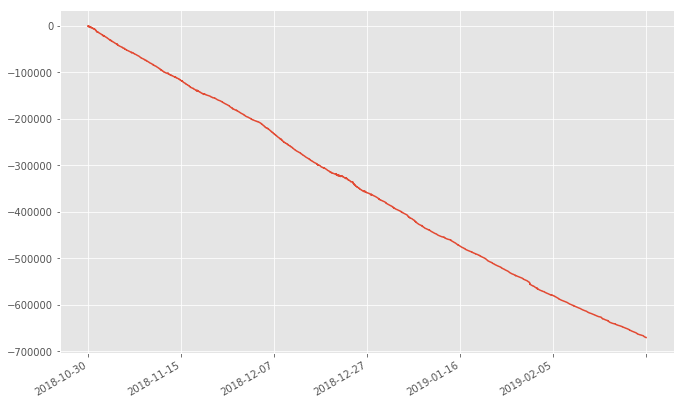

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter

class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(x)
        if ind >= len(self.dates) or ind < 0:
            return ''
        else:
            return self.dates[ind].strftime(self.fmt)

plt.style.use("ggplot")
formatter = MyFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl.shape[0]), np.cumsum(pnl))
fig.autofmt_xdate()
plt.show()

# Statistics

In [11]:
def annual_sharpe(pnl):
    mean = pnl.mean()
    var = pnl.std()
    day_sharpe = (mean / var) * np.sqrt(390)
    year_sharpe = day_sharpe * np.sqrt(252)
    return year_sharpe

def annual_return(pnl, principal=1000000):    
    ret = pnl / principal
    return np.mean(ret) * 390 * 252

def annual_volatility(pnl, principal=1000000):
    log_ret = np.log(1 + pnl / principal)
    return log_ret.std() * np.sqrt(252)

def annual_turnover(weights):
    turnover = np.sum(np.abs(weights[1:] - weights[:-1])) / weights.shape[0]
    return turnover * 390 * 252

def maximum_drawdown(pnl):
    cum_pnl = np.cumsum(pnl)
    ind = np.argmax(np.maximum.accumulate(cum_pnl) - cum_pnl)
    return (np.maximum.accumulate(cum_pnl)[ind] - cum_pnl[ind]) / np.maximum.accumulate(cum_pnl)[ind]

def print_statistics(pnl, actions):
    print("Annual Sharpe: {}".format(annual_sharpe(pnl)))
    print("Annual Return: {}".format(annual_return(pnl)))
    print("Annual Volatility: {}".format(annual_volatility(pnl)))
    print("Annual Turnover: {}".format(annual_turnover(actions)))
    print("Maximum Drawdown: {}".format(maximum_drawdown(pnl)))  
    
print_statistics(pnl, actions)

Annual Sharpe: -130.62469755572786
Annual Return: -2.196140737922053
Annual Volatility: 0.0008514407375726492
Annual Turnover: 15334.63927734375
Maximum Drawdown: 26324.134765625
